In [1]:
using FunctionalCollections
using Iterators
using Pipe
using Compat

macro printval(ee)
    ee_expr = @sprintf "%s" string(ee)
    esc(:(println($ee_expr," = ", $ee)))
end

macro pz(ee)
    ee_expr = @sprintf "%s" string(ee)
    esc(:(println($ee_expr,"\t\t",typeof($ee), "\t", size($ee))))
end

push!(LOAD_PATH, ".")
push!(LOAD_PATH, "../util/")
using DataStructures
using DataStructuresExtended

In [73]:
OUTPUT_DIR = "../../documents_prepared/Journal\ Papers/SumResynthesis/data/"

"../../documents_prepared/Journal Papers/SumResynthesis/data/"

In [106]:
`git add ../../documents_prepared/Journal\ Papers/SumResynthesis/data/ordering_scores.csv` |> run

In [110]:
`git push` |> run

To git@github.com:oxinabox/phd.git
   8cf6222..4d54a44  master -> master


In [2]:
using JLD

In [3]:
function jaccard_index(aa::DataStructures.Accumulator,bb::DataStructures.Accumulator)
    sum(intersect(aa,bb))/sum(union(aa,bb))
end

function jaccard_index(aa,bb)
    length(intersect(aa,bb))/length(union(aa,bb))
end

jaccard_index (generic function with 2 methods)

In [4]:


brown_glove300_raw = load("results/bags/brown_glove300_res.jld", "res")
brown_glove200_raw = load("results/bags/brown_glove200_res.jld", "res")
brown_glove100_raw = load("results/bags/brown_glove100_res.jld", "res")
brown_glove50_raw = load("results/bags/brown_glove50_res.jld", "res")

42004-element Array{Any,1}:
 (ASCIIString["``","only","a","relative","handful","of","such","reports","was","received"  …  "of","voters","and","the","size","of","this","city","''","."],ASCIIString["that","that","that","that","that","that","that","it","that","of"  …  "marginal","marc","thereon","gunning","ledford","market-place","included","on","than","as"],-2.6416790753173873)                               
 (ASCIIString["it","recommended","that","fulton","legislators","act","``","to","have","these"  …  "to","the","end","of","modernizing","and","improving","them","''","."],ASCIIString["we","not","not","government","it","its","law","these","to","in"  …  "revised","jenks","selma","recurrent","reuben","tracked","should","there","symbolically","working"],-3.467678697624857)            
 (ASCIIString["the","grand","jury","commented","on","a","number","of","other","topics"  …  "inure","to","the","best","interest","of","both","governments","''","."],ASCIIString["they","have","have","they","tha

In [5]:
@assert all([rset[1] for rset in brown_glove50_raw] .== [rset[1] for rset in brown_glove300_raw])
@assert all([rset[1] for rset in brown_glove50_raw] .== [rset[1] for rset in brown_glove200_raw])
@assert all([rset[1] for rset in brown_glove50_raw] .== [rset[1] for rset in brown_glove100_raw])

In [6]:
using DataFrames

In [7]:
bag_res = DataFrame()
bag_res[:ground] = [counter(rset[1]) for rset in brown_glove50_raw]
bag_res[:ground_len] = Int[sum(ss) for ss in bag_res[:ground]]
exp_names = ASCIIString[]
for raw_name in ["brown_glove50_raw","brown_glove100_raw", "brown_glove200_raw", "brown_glove300_raw"]
    colname = split(raw_name,"_")[2] 
    push!(exp_names, colname)
    raw = eval(raw_name|>Symbol)
    bag_res[colname*"_actual"|> Symbol] = [counter(rset[2]) for rset in raw]
    #bag_res[colname*"_distance"|> Symbol] = Float64[-1*rset[3] for rset in raw]
end

bag_res

,ground,ground_len,glove50_actual,glove100_actual,glove200_actual,glove300_actual
1,"DataStructures.Accumulator{ASCIIString,Int64}(Dict(""widespread""=>1,""jury""=>1,""number""=>1,""``""=>2,""such""=>1,""a""=>1,""was""=>1,""and""=>1,""handful""=>1,"",""=>3,""reports""=>1,""relative""=>1,""considering""=>1,""this""=>1,""received""=>1,""in""=>1,"".""=>1,""''""=>2,""the""=>5,""election""=>1,""voters""=>1,""said""=>1,""size""=>1,""interest""=>1,""of""=>3,""only""=>1,""city""=>1))",37,"DataStructures.Accumulator{ASCIIString,Int64}(Dict(""public""=>1,""percent""=>1,""general""=>1,""national""=>1,""marc""=>1,""people""=>1,""a""=>2,""more""=>1,""that""=>9,""this""=>1,""petty""=>1,""it""=>1,""in""=>3,""market-place""=>1,""included""=>1,""charlotte""=>1,"":""=>1,""attu""=>1,""the""=>1,""gunning""=>1,""ledford""=>1,""awards""=>1,""of""=>3,""marginal""=>1,""on""=>1,""as""=>1,""he""=>1,""stark""=>1,""thereon""=>1,""than""=>1))","DataStructures.Accumulator{ASCIIString,Int64}(Dict(""public""=>1,""flats""=>1,""los""=>1,""scant""=>1,""relative""=>1,""more""=>1,""that""=>5,""twenty-one-year-old""=>1,""an""=>1,""list""=>1,""sec.""=>1,""aiche""=>1,""of""=>3,""farmer""=>1,""gangplank""=>1,""grinned""=>1,""in""=>2,""mccormack""=>1,""reacted""=>1,""referring""=>1,""husband-wife""=>1,""convocations""=>1,""than""=>1,""naming""=>1,""arcilla""=>1,""they""=>1,""``""=>1,""higher""=>1,""for""=>1,"",""=>3,""ego""=>1,""espagnol""=>1,""''""=>1,""salutaris""=>1,""barbara""=>1,""nassau""=>1,""which""=>1,""number""=>1,""luthuli""=>1,""reporting""=>1,""the""=>5,""election""=>1,""rolling""=>1,""lesser""=>1,""old-timer""=>1))","DataStructures.Accumulator{ASCIIString,Int64}(Dict(""public""=>1,""i-e""=>1,""pulls""=>1,""relative""=>1,""more""=>1,""that""=>2,""also""=>1,""parioli""=>1,""jeff""=>1,""westport""=>1,""0.039""=>1,""of""=>5,""stirling""=>1,""convinced""=>1,""percent""=>1,""rhythm-and-blues""=>1,""elections""=>1,""announcement""=>1,""have""=>1,""in""=>1,""snodgrass""=>1,""unrelated""=>1,""were""=>1,""sergeant""=>1,""``""=>3,""judge""=>1,""for""=>1,""fading""=>1,"",""=>3,""press""=>1,""emergencies""=>1,""furs""=>1,""jeepers""=>1,""no""=>1,""a""=>1,""this""=>1,""toured""=>1,""mauler""=>1,""selection""=>1,""greek-speaking""=>1,""the""=>4,""voter""=>1,""size""=>1))","DataStructures.Accumulator{ASCIIString,Int64}(Dict(""ran""=>1,""number""=>1,""jury""=>1,""widespread""=>1,""``""=>4,""any""=>1,""meanwhile""=>1,""a""=>1,"",""=>3,""relative""=>1,""this""=>1,""received""=>1,""it""=>1,""23-year-old""=>1,""in""=>1,""include""=>1,"".""=>1,""the""=>4,""example""=>1,""election""=>1,""voters""=>1,""said""=>1,""size""=>1,""were""=>1,""interest""=>1,""of""=>4,""city""=>1,""unavailable""=>1))"
2,"DataStructures.Accumulator{ASCIIString,Int64}(Dict(""recommended""=>1,""``""=>1,""studied""=>1,""and""=>2,""that""=>1,""these""=>1,""modernizing""=>1,""it""=>1,""have""=>1,"".""=>1,""improving""=>1,""act""=>1,""''""=>1,""the""=>1,""end""=>1,""legislators""=>1,""of""=>1,""them""=>1,""revised""=>1,""fulton""=>1,""laws""=>1,""to""=>2))",24,"DataStructures.Accumulator{ASCIIString,Int64}(Dict(""there""=>1,""we""=>1,""not""=>2,""working""=>1,""government""=>1,""and""=>3,""selma""=>1,""these""=>1,""it""=>1,""in""=>1,""reuben""=>1,""recurrent""=>1,""tracked""=>1,""should""=>1,""law""=>2,""new""=>1,""its""=>1,""measures""=>1,""revised""=>1,""jenks""=>1,""to""=>1,""symbolically""=>1))","DataStructures.Accumulator{ASCIIString,Int64}(Dict(""they""=>1,""keyboarding""=>1,""l'ange""=>1,""weatherbeaten""=>1,""and""=>2,""for""=>1,""that""=>4,""throughout""=>1,""it""=>1,""neo-romanticism""=>1,""codfish""=>1,""their""=>1,""reacting""=>1,""wheeler""=>1,""reform""=>1,""all""=>1,""law""=>2,""new""=>1,""those""=>1,""revised""=>1,""albany""=>1,""huai""=>1,""respectively""=>1,""to""=>2,""supervising""=>1))","DataStructures.Accumulator{ASCIIString,Int64}(Dict(""recommended""=>1,""``""=>1,""studied""=>1,""and""=>2,""while""=>1,""that""=>1,""these""=>1,""modernizing""=>1,""it""=>1,""have""=>1,"".""=>1,""improve"

In [8]:
for exp_name in exp_names
    actual = bag_res[exp_name*"_actual" |> symbol]
    bag_res[exp_name*"_perfect" |> symbol] = actual.==bag_res[:ground]
    bag_res[exp_name*"_jaccard" |> symbol] = map(jaccard_index, actual, bag_res[:ground])
end

In [145]:

jaccard_cols = Symbol[exp_name*"_jaccard" |> symbol for exp_name in exp_names]
perfect_cols = Symbol[exp_name*"_perfect" |> symbol for exp_name in exp_names]
len_scores = aggregate(bag_res[[:ground_len, jaccard_cols...,perfect_cols...]], :ground_len, mean)
sort!(len_scores)
writetable(OUTPUT_DIR*"selection_len_scores.csv", len_scores)
len_scores

,ground_len,glove50_jaccard_mean,glove100_jaccard_mean,glove200_jaccard_mean,glove300_jaccard_mean,glove50_perfect_mean,glove100_perfect_mean,glove200_perfect_mean,glove300_perfect_mean
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2,0.9254761904761903,0.9966666666666666,1.0,1.0,0.9185714285714286,0.9957142857142857,1.0,1.0
3,3,0.7318763326226013,0.9807131011608624,0.9972139303482588,1.0,0.6786069651741293,0.9751243781094527,0.9960199004975124,1.0
4,4,0.5249530619129383,0.9586227872493305,0.9968106995884773,1.0,0.4094650205761317,0.9351851851851852,0.9948559670781894,1.0
5,5,0.4170598709932043,0.9096075134741801,0.9917139329805997,0.9979682539682541,0.2791111111111111,0.8622222222222222,0.984,0.9964444444444445
6,6,0.27045744927639337,0.8475435844692085,0.9846264908068917,0.9946795347686217,0.11804008908685969,0.7535263548626577,0.9703043801039347,0.9896065330363771
7,7,0.20260415575296167,0.7791404873241873,0.9813278987034174,0.9960811433840479,0.04979253112033195,0.6479944674965422,0.9612724757952974,0.9910096818810512
8,8,0.16832011779368286,0.6754646740789194,0.9792745870721682,0.993938108005581,0.0241884150222788,0.49713558243157224,0.9528962444302992,0.9847231063017187
9,9,0.14011375429256256,0.5801273500758415,0.9598561201432879,0.992864371503313,0.00630119722747322,0.3629489603024575,0.909892879647133,0.9785759294265911
10,10,0.13231436739735566,0.49544301610882335,0.9406913437669053,0.9897730104726254,0.0038510911424903724,0.2374839537869063,0.8709884467265725,0.9698331193838254


4-element Array{Symbol,1}:
 :glove50_perfect 
 :glove100_perfect
 :glove200_perfect
 :glove300_perfect

In [149]:
cum_len_scores = DataFrame()
cum_len_scores[:max_ground_len] = bag_res[:ground_len] |> unique |> sort!
for jaccard_col in jaccard_cols
    cum_len_scores[jaccard_col] = Float64[ begin
            shortish_sents = bag_res[:ground_len] .<= max_len;
            bag_res[shortish_sents, jaccard_col] |> mean
         end for max_len in cum_len_scores[:max_ground_len]]
end
for perfect_col in perfect_cols
    cum_len_scores[perfect_col] = Float64[ begin
            shortish_sents = bag_res[:ground_len] .<= max_len;
            bag_res[shortish_sents, perfect_col] |> mean
         end for max_len in cum_len_scores[:max_ground_len]]
end
writetable(OUTPUT_DIR*"selection_cum_len_scores.csv", cum_len_scores)
cum_len_scores 


,max_ground_len,glove50_jaccard,glove100_jaccard,glove200_jaccard,glove300_jaccard,glove50_perfect,glove100_perfect,glove200_perfect,glove300_perfect
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2,0.9489562948467059,0.9977168949771689,1.0,1.0,0.9442270058708415,0.99706457925636,1.0,1.0
3,3,0.8413266145135904,0.9892863015951323,0.9986186482486433,1.0,0.8125308337444499,0.9861864824864331,0.9980266403552047,1.0
4,4,0.7387874037340525,0.9793480101832887,0.9980326775591863,1.0,0.6818939646548849,0.9696565521840613,0.9969989996665555,1.0
5,5,0.6510222547686175,0.9603232626571617,0.99630896571367,0.9994457530829987,0.5720174587778856,0.9403491755577109,0.9934529582929195,0.9990300678952473
6,6,0.5573244311535516,0.9325560854465654,0.9934326554048724,0.9982722754610892,0.46024492780113324,0.8943520380186437,0.9877536099433376,0.9967099250594041
7,7,0.4831700986063123,0.9004845291526578,0.9909021540039322,0.9978142189360926,0.374439786034408,0.842850946942316,0.9822177244470146,0.9955182882752639
8,8,0.42489614480604837,0.8588367685116536,0.9887500678057937,0.9970968096203723,0.30961357210179075,0.7788642789820923,0.9767907634307257,0.9935202639019792
9,9,0.38003761837975536,0.8149348482081664,0.9841987333203944,0.9964301218494765,0.2618362282878412,0.7133498759305211,0.9662531017369727,0.991166253101737
10,10,0.34686020713325155,0.772145518335324,0.9783718173980754,0.9955385393234616,0.2272844494111579,0.6496174675492135,0.9534943694661738,0.988309120605175


In [11]:
function longform(df::DataFrame, index::Symbol, cols::Vector{Symbol}, new_name::Symbol)
    function subdf(col::Symbol)
        df_sub = df[[index, col]]
        rename!(df_sub, col, new_name)
        df_sub[:label] = col
        df_sub
    end
    vcat([subdf(col) for col in cols]...)
end




longform (generic function with 1 method)

In [12]:
using Gadfly

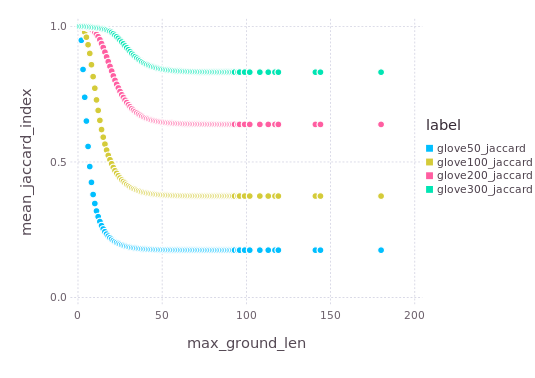

In [13]:
p=Gadfly.plot(longform(cum_len_scores, :max_ground_len, jaccard_cols, :mean_jaccard_index),
    x="max_ground_len", y="mean_jaccard_index",
    color="label",
    Geom.point
)
#draw(PNG("brown_cumulative_length_score.png", 24cm, 6cm), p)

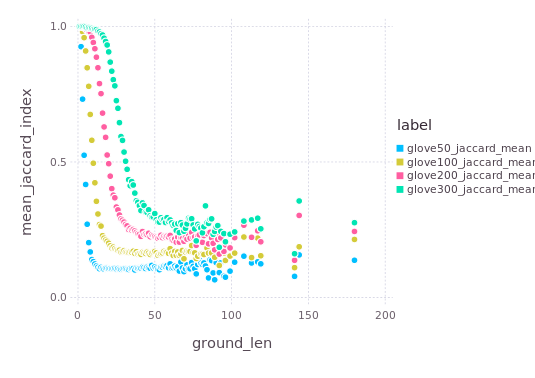

In [14]:

p=Gadfly.plot(longform(len_scores, :ground_len, [string(col)*"_mean"|> Symbol for col in jaccard_cols], :mean_jaccard_index),
    x="ground_len", y="mean_jaccard_index",
    color="label",
    Geom.point
)
#draw(PNG("brown_length_score.png", 24cm, 6cm), p)


Summary Stats:


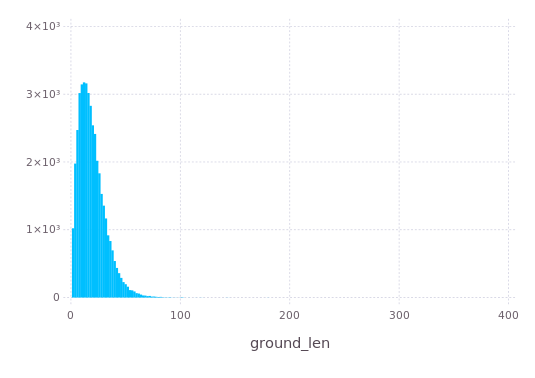

Mean:         18.813708
Minimum:      1.000000
1st Quartile: 10.000000
Median:       17.000000
3rd Quartile: 25.000000
Maximum:      180.000000


In [86]:
bag_res[:ground_len] |> describe 
p=Gadfly.plot(bag_res, x="ground_len",  Geom.histogram)
#draw(PNG("brown_length_dist.png", 24cm, 6cm), p)

In [20]:
##############################################
# ORDERED
########################################

Mean:         18.813708
Minimum:      1.000000
1st Quartile: 10.000000
Median:       17.000000
3rd Quartile: 25.000000
Maximum:      180.000000


In [21]:
using PyCall
@pyimport nltk
@pyimport nltk.align.bleu_score as nltk_bleu

function bleu_score(candidate, reference)
    reference = reference |> collect
    candidate = candidate |> collect
    
    if reference==candidate #Perfect Match
        1.0
    else
        weights = [1,1,1,1]/4
        nltk_bleu.bleu(candidate,Any[reference], weights)
    end
end

/usr/local/lib/python2.7/dist-packages/nltk/app/__init__.py:29: UserWarning: nltk.app package not loaded (please install Tkinter library).
  warnings.warn("nltk.app package not loaded "
/usr/local/lib/python2.7/dist-packages/nltk/draw/__init__.py:15: UserWarning: nltk.draw package not loaded (please install Tkinter library).
  warnings.warn("nltk.draw package not loaded "


bleu_score (generic function with 1 method)

In [91]:
folds50 = load("results/ordered/brown_glove50_ordered.jld")
folds100 = load("results/ordered/brown_glove100_ordered.jld")
folds200 = load("results/ordered/brown_glove200_ordered.jld")
folds300 = load("results/ordered/brown_glove300_ordered.jld")
folds_oracle = load("results/ordered/oracle_ordered.jld")
all_ordered_exp_folds = Any[folds50,folds100,folds200,folds300,folds_oracle]

Dict{ByteString,Any} with 10 entries:
  "fold_6"  => Any[(ASCIIString["the","songs","sandburg","sang","often","remind…
  "fold_5"  => Any[(ASCIIString["the","brush","moves","up","and","down","and","…
  "fold_2"  => Any[(ASCIIString["by","september","1940","the","suite","had","de…
  "fold_9"  => Any[(ASCIIString["to","begin","the","interview",",","he","asked"…
  "fold_7"  => Any[(ASCIIString["he","finds","the","structure","contains","an",…
  "fold_1"  => Any[(ASCIIString["."],ASCIIString(.),1.0),(ASCIIString["but","he…
  "fold_8"  => Any[(ASCIIString["word","reached","the","company","that","the","…
  "fold_3"  => Any[(ASCIIString["with","this","ultimate","weapon",",","the","tw…
  "fold_10" => Any[(ASCIIString["thus","a","new","pattern","of","days","began",…
  "fold_4"  => Any[(ASCIIString["banks","the","butcher","took","meltzer","the",…

In [154]:
function get_bleu_score(folds; count_give_ups=true, count_nonattepts=false)
    bleu_scores = map(keys(folds), values(folds)) do fold_name,res
        fold_bleu_scores = Float64[]
        for (reference, candidate, prob) in res
            if ((!count_nonattepts && isnan(prob))  
                || (!count_give_ups && prob==0.0))
                continue
            end
            push!(fold_bleu_scores, bleu_score(candidate, reference))
        end
        fold_bleu_scores
    end
end

get_bleu_score (generic function with 1 method)

In [155]:
bleu_scores = map(all_ordered_exp_folds) do folds
    bleu_scores = get_bleu_score(folds);
    map(mean, bleu_scores) |> mean
end


5-element Array{Any,1}:
 0.110817
 0.331907
 0.686167
 0.844583
 0.879902

In [156]:
bleu_scores_no_giveup = map(all_ordered_exp_folds) do folds
    bleu_scores = get_bleu_score(folds, count_give_ups=false);
    map(mean, bleu_scores) |> mean
end


,Model,BLEU Score,Exact Ordered Matches,Giveups,BLEU Score Excluding Giveups,Exact Ordered Matches Excluding Giveups
1,glove50,0.11081747544719919,0.11065787444285675,0.8883766683256147,0.9920752142292841,0.9914300544524333
2,glove100,0.33190740464924795,0.3296886524724448,0.6656816405213786,0.992324058028608,0.9861446827510856
3,glove200,0.6861674754568605,0.6634715937520844,0.3034246817969815,0.9846003980086131,0.9525131750438494
4,glove300,0.844582634764274,0.80656724116484,0.14025647095176239,0.9820766892450947,0.9381569147586234


In [157]:
attempted_only(fold) = filter(eap->!isnan(eap[3]), fold)
nongiveup_only(fold) = filter(eap->eap[3]>0, fold)

nongiveup_only (generic function with 1 method)

In [158]:
giveups = map(all_ordered_exp_folds) do folds
    mean([mean(Bool[eap[3]==0.0 for eap in attempted_only(fold)]) for fold in values(folds)])
end

5-element Array{Any,1}:
 0.888377
 0.665682
 0.303425
 0.140256
 0.104948

In [159]:
exact_matchs = map(all_ordered_exp_folds) do folds
    mean([mean(Bool[eap[1]==eap[2] for eap in attempted_only(fold)]) for fold in values(folds)])
end

5-element Array{Any,1}:
 0.110658
 0.329689
 0.663472
 0.806567
 0.839361

In [160]:
exact_matchs_no_giveup = map(all_ordered_exp_folds) do folds
    mean([mean(Bool[eap[1]==eap[2] for eap in nongiveup_only(attempted_only(fold))]) for fold in values(folds)])
end

5-element Array{Any,1}:
 0.99143 
 0.986145
 0.952513
 0.938157
 0.937788

In [161]:
ordering_res = DataFrame(Model=[exp_names..., "Oracle BOW"])
ordering_res[symbol("BLEU Score")]=bleu_scores
ordering_res[symbol("Exact Ordered Matches")]=exact_matchs
ordering_res[symbol("Giveups")]=giveups
ordering_res[symbol("BLEU Score Excluding Giveups")]=bleu_scores_no_giveup
ordering_res[symbol("Exact Ordered Matches Excluding Giveups")]=exact_matchs_no_giveup
writetable(OUTPUT_DIR*"ordering_scores.csv", ordering_res)
ordering_res

,Model,BLEU Score,Exact Ordered Matches,Giveups,BLEU Score Excluding Giveups,Exact Ordered Matches Excluding Giveups
1,glove50,0.11081747544719919,0.11065787444285675,0.8883766683256147,0.9920752142292841,0.9914300544524333
2,glove100,0.33190740464924795,0.3296886524724448,0.6656816405213786,0.992324058028608,0.9861446827510856
3,glove200,0.6861674754568605,0.6634715937520844,0.3034246817969815,0.9846003980086131,0.9525131750438494
4,glove300,0.844582634764274,0.80656724116484,0.14025647095176239,0.9820766892450947,0.9381569147586234
5,oracle BOW,0.8799022829001693,0.8393612490410491,0.1049481808340041,0.9828686635948211,0.9377880036360496


In [62]:
########

In [79]:
fold_indexes=load("brown_glove_folds.jld","fold_indexes");

In [48]:
function fold(data, fold_indexes)
    ret = Dict()
    for (fold_number,fold_iis) in enumerate(fold_indexes)
        ret["fold_$(fold_number)"] = data[fold_iis]
    end
    ret
end

fold (generic function with 1 method)

In [50]:
jaccard_folds_300 = fold(bag_res[:glove300_jaccard], fold_indexes)

Dict{Any,Any} with 10 entries:
  "fold_6"  => [1.0,1.0,1.0,0.8,0.5,1.0,1.0,1.0,1.0,0.351852  …  0.257143,1.0,0…
  "fold_5"  => [1.0,1.0,1.0,1.0,0.319149,1.0,1.0,1.0,1.0,0.342857  …  1.0,1.0,1…
  "fold_2"  => [1.0,1.0,1.0,1.0,0.386364,0.526316,0.538462,1.0,1.0,1.0  …  1.0,…
  "fold_9"  => [0.536585,1.0,1.0,0.514286,0.341176,1.0,1.0,1.0,0.684211,0.81818…
  "fold_7"  => [1.0,1.0,0.264463,1.0,0.2875,1.0,1.0,1.0,1.0,0.958333  …  1.0,1.…
  "fold_1"  => [1.0,1.0,1.0,1.0,0.302326,1.0,1.0,1.0,1.0,1.0  …  1.0,1.0,1.0,1.…
  "fold_8"  => [0.303571,0.293333,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.307692  …  0.69…
  "fold_3"  => [1.0,1.0,1.0,0.294872,1.0,0.21875,1.0,1.0,1.0,1.0  …  1.0,1.0,1.…
  "fold_4"  => [0.276316,1.0,0.818182,0.568182,1.0,0.333333,1.0,0.285714,0.6388…
  "fold_10" => [1.0,0.292308,0.26087,1.0,1.0,1.0,1.0,1.0,1.0,1.0  …  1.0,0.2702…

In [53]:
[jaccard_folds_300["fold_6"] bleu_scores300[1]]

LoadError: LoadError: ArgumentError: number of rows of each array must match (got (4200,2406))
while loading In[53], in expression starting on line 1

In [81]:
get_bleu_score(folds300,  count_give_ups=true, count_nonattepts=true);